In [ ]:
#Descarga libreria Libtorch
! wget https://download.pytorch.org/libtorch/cu126/libtorch-shared-with-deps-2.8.0%2Bcu126.zip -O libtorch.zip

--2025-08-25 15:30:10--  https://download.pytorch.org/libtorch/cu126/libtorch-shared-with-deps-2.8.0%2Bcu126.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.239.225.41, 18.239.225.61, 18.239.225.75, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.239.225.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2907946879 (2.7G) [binary/octet-stream]
Saving to: ‘libtorch.zip’

libtorch.zip        100%[===================>]   2.71G   115MB/s    in 22s     

2025-08-25 15:30:33 (126 MB/s) - ‘libtorch.zip’ saved [2907946879/2907946879]



In [ ]:
#Se descomprime
! unzip libtorch.zip


Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: libtorch/include/ATen/ops/le.h  
  inflating: libtorch/include/ATen/ops/le_compositeexplicitautogradnonfunctional_dispatch.h  
  inflating: libtorch/include/ATen/ops/le_cpu_dispatch.h  
  inflating: libtorch/include/ATen/ops/le_cuda_dispatch.h  
  inflating: libtorch/include/ATen/ops/le_meta.h  
  inflating: libtorch/include/ATen/ops/le_meta_dispatch.h  
  inflating: libtorch/include/ATen/ops/le_native.h  
  inflating: libtorch/include/ATen/ops/le_ops.h  
  inflating: libtorch/include/ATen/ops/leaky_relu.h  
  inflating: libtorch/include/ATen/ops/leaky_relu_backward.h  
  inflating: libtorch/include/ATen/ops/leaky_relu_backward_compositeexplicitautogradnonfunctional_dispatch.h  
  inflating: libtorch/include/ATen/ops/leaky_relu_backward_cpu_dispatch.h  
  inflating: libtorch/include/ATen/ops/leaky_relu_backward_cuda_dispatch.h  
  inflating: libtorch/include/ATen/ops/leaky_relu_backward_meta.h  
  inflating

In [ ]:
#Se instala cmake
! apt-get install -y cmake

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
#Propgador en Python
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from argparse import Namespace

def ASMprop(args):
    wl=args.wl # Longitud de onda
    dx=args.dx # Paso en x
    dy=args.dy # Paso en y
    sx=args.sx # Tamaño en x
    sy=args.sy # Tamaño en y
    z=args.z # Distancia de propagación
    angx=torch.asin(torch.tensor(wl/(2*dx))) # Angulo de propagación en x
    angy=torch.asin(torch.tensor(wl/(2*dy))) # Angulo de propagación en y
    margx=torch.abs(torch.tensor(z))*torch.tan(angx) # Margen de propagación en x
    margx=torch.ceil(margx/dx) # Redondeo al entero más cercano
    margy=torch.abs(torch.tensor(z))*torch.tan(angy) # Margen de propagación en y
    margy=torch.ceil(margy/dy) # Redondeo al entero más cercano
    margx=margx.int().item() # Redondeo a entero
    margy=margy.int().item() # Redondeo a entero
    if margx> 1000 or margy> 1000:
        print('Precaucion: Los parametros de propagacíon implican un padding de mas de ',margx, ' píxeles')
    fieldpad=torch.zeros((1,1,sy,sx)) # Crear un tensor de ceros con las dimensiones dadas
    pad=nn.ConstantPad2d((margy,margy,margx,margx),0) # Crear un objeto de padding constante
    fieldpad=pad(fieldpad) # Aplicar el padding al tensor de ceros ?
    spy=fieldpad.shape[2] # Tamaño en y del tensor con padding
    spx=fieldpad.shape[3] # Tamaño en x del tensor con padding
    Tfx=1/dx # Periodo en x
    dfx=Tfx/spx # Paso en x del espacio de frecuencias
    Tfy=1/dy # Periodo en y
    dfy=Tfy/spy # Paso en y del espacio de frecuencias
    if np.remainder(spx,2)==0: # Si el tamaño en x es par
        fx=torch.arange(-Tfx/2,Tfx/2,dfx) # Crear un tensor de frecuencias en x
    else:
        fx=torch.arange(-(Tfx/2-dfx)/2,(Tfx-dfx)/2,dfx) # Crear un tensor de frecuencias en x con un ajuste para tamaños impares
    if np.remainder(spy,2)==0:
        fy=torch.arange(-Tfy/2,Tfy/2,dfy)
    else:
        fy=torch.arange(-(Tfy/2-dfy)/2,(Tfy-dfy)/2,dfy)

    Fx,Fy=torch.meshgrid(fx,fy,indexing='xy') # Crear una malla de frecuencias en x e y
    Gamma=(1/(wl**2))-Fx**2-Fy**2
    Prop=torch.exp(2*1j*torch.pi*torch.sqrt(Gamma)*z) # Calcular la función de tranferencia
    Prop = torch.fft.ifftshift(Prop) # Aplicar un shift inverso de Fourier
    return Prop

def ASM(A,Prop):
    """Esta funcion permite propagar una imagen A usando la funcion de transferencia Prop.
    La imagen A debe ser un tensor de pytorch, con dimensiones ordenadas en forma de imagen [H,W,C].
    Prop debe ser un tensor de pytorch, con dimensiones ordenadas en forma de imagen [H,W,C].
    La funcion devuelve un tensor de pytorch con las dimensiones de A, pero con la imagen propagada."""
    n = A.shape[-2] # Numero de filas de la imagen A
    m = A.shape[-1] # Numero de columnas de la imagen A
    ns= Prop.shape[-2] # Numero de filas de la funcion de transferencia Prop
    mm= Prop.shape[-1] # Numero de columnas de la funcion de transferencia Prop

    if (mm-m)%2 ==0: # Si la diferencia entre el numero de columnas de la funcion de transferencia y la imagen es par
        margx1=(mm-m)/2 # mitad de columnas a agregar a la izquierda
        margx1=np.floor(margx1) # Redondeo hacia abajo
        margx2=(mm-m)/2 # mitad de columnas a agregar a la derecha
        margx2=np.floor(margx2)
    else:
        margx1=(mm-m)/2 # mitad de columnas a agregar a la izquierda
        margx1=np.floor(margx1)
        margx2=(mm-m)/2+1 # columna adicional a agregar a la derecha
        margx2=np.floor(margx2)
    # Lo mismo para las filas:
    if (ns-n)%2 ==0:
        margy1=(ns-n)/2
        margy1=np.floor(margy1)
        margy2=(ns-n)/2
        margy2=np.floor(margy2)
    else:
        margy1=(ns-n)/2
        margy1=np.floor(margy1)
        margy2=(ns-n)/2+1
        margy2=np.floor(margy2)
    # Convertir los margenes a enteros
    margx1=int(margx1)
    margx2=int(margx2)
    margy1=int(margy1)
    margy2=int(margy2)


    pad=nn.ConstantPad2d((margx1,margx2,margy1,margy2),0) # Crear un objeto de padding constante
    A=pad(A) # Aplicar el padding a la imagen A

    A=torch.fft.fft2(torch.fft.ifftshift(A)) # Transformar A a la frecuencia
    A=torch.fft.fftshift(torch.fft.ifft2(A*Prop)) # Aplicar la funcion de transferencia Prop a A
    R=A[..., int(margy1):A.shape[-2]-int(margy2), int(margx1):A.shape[-1]-int(margx2)] # Recortar la imagen A para que tenga las mismas dimensiones que la imagen original
    return R

In [ ]:
%cd content

/content


In [ ]:
%%writefile asm.h

#include <torch/torch.h>
#include <complex>
#include <iostream>
#include <fstream>
#include <cmath>

// Estructura de parámetros
struct ASMArgs {
    double wl; // Longitud de onda
    double dx; // Paso en x
    double dy; // Paso en y
    int sx;    // Tamaño en x
    int sy;    // Tamaño en y
    int tx;    // Tamaño en x del rectángulo
    int ty;    // Tamaño en y del rectángulo
    int r;     // Radio del círculo
    double z;  // Distancia de propagación
};

class RectangularMask {
public:
    static torch::Tensor create(int height, int width,
                               int rect_height, int rect_width,
                               int center_x = -1, int center_y = -1);
};

class CircularMask {
public:
    static torch::Tensor create(int height, int width,
                               float radius,
                               int center_x = -1, int center_y = -1);
};

// // Calcula la función de transferencia Prop
// torch::Tensor ASMprop(const ASMArgs& args);

// // Propaga una imagen A usando la transferencia Prop
// torch::Tensor ASM(const torch::Tensor& A, const torch::Tensor& Prop);

class ASM {
    public:
        // Constructor
        ASM(const torch::Tensor& A);

        torch::Tensor A;
        torch::Tensor TransferFunction;

        void ASMprop(const ASMArgs& args);
        torch::Tensor propagate();

};

//Escribe un archivo
void exportToCSV( const torch::Tensor& A,
                  const torch::Tensor& R,
                  const std::string& amplitude_filename,
                  const std::string& phase_filename,
                  int sy, int sx);

Overwriting asm.h


In [ ]:
%%writefile asm.cpp
#include "asm.h"
#include <cmath>
#include <fstream>
#include <iostream>

// ====================================================================
// Función ASMprop
// Calcula la función de transferencia de propagación (Prop)
// usando el método del espectro angular.
// ====================================================================
ASM::ASM(const torch::Tensor& A_) : A(A_) {}

void ASM::ASMprop(const ASMArgs& args) {
    using namespace torch::indexing;

    // Parámetros
    double wl = args.wl;   // Longitud de onda
    double dx = args.dx;   // Paso en x
    double dy = args.dy;   // Paso en y
    int sx = args.sx;      // Tamaño en x
    int sy = args.sy;      // Tamaño en y
    double z = args.z;     // Distancia de propagación

    // Cálculo de los ángulos de propagación máximo (Nyquist)
    double angx = std::asin(wl / (2 * dx));
    double angy = std::asin(wl / (2 * dy));

    // Márgenes necesarios para evitar aliasing
    int margx = static_cast<int>(std::ceil(std::abs(z) * std::tan(angx) / dx));
    int margy = static_cast<int>(std::ceil(std::abs(z) * std::tan(angy) / dy));

    if (margx > 1000 || margy > 1000) {
        std::cout << "Precaucion: El padding es mayor a " << margx << " pixeles" << std::endl;
    }

    // Crear un tensor de ceros (campo inicial) y aplicar padding
    auto fieldpad = torch::zeros({1, 1, sy, sx}, torch::kFloat64);
    torch::nn::ConstantPad2d pad(torch::nn::ConstantPad2dOptions({margy, margy, margx, margx}, 0));
    fieldpad = pad(fieldpad);

    // Dimensiones después del padding
    int spy = fieldpad.size(2);
    int spx = fieldpad.size(3);

    // Resolución espacial en el dominio de frecuencias
    double Tfx = 1.0 / dx;
    double dfx = Tfx / spx;
    double Tfy = 1.0 / dy;
    double dfy = Tfy / spy;

    // Construcción de los ejes de frecuencias fx y fy
    torch::Tensor fx, fy;
    if (spx % 2 == 0) {
        fx = torch::arange(-Tfx / 2.0, Tfx / 2.0, dfx, torch::kFloat64);
    } else {
        fx = torch::arange(-(Tfx / 2.0 - dfx) / 2.0, (Tfx - dfx) / 2.0, dfx, torch::kFloat64);
    }

    if (spy % 2 == 0) {
        fy = torch::arange(-Tfy / 2.0, Tfy / 2.0, dfy, torch::kFloat64);
    } else {
        fy = torch::arange(-(Tfy / 2.0 - dfy) / 2.0, (Tfy - dfy) / 2.0, dfy, torch::kFloat64);
    }

    // Crear malla bidimensional de frecuencias
    auto grids = torch::meshgrid({fx, fy}, "xy");
    fx = grids[0];
    fy = grids[1];

    // Cálculo del término Gamma
    auto Gamma = (1.0 / (wl * wl)) - fx.pow(2) - fy.pow(2);

    // Fase de propagación
    auto phase = 2 * M_PI * torch::sqrt(Gamma) * z;

    // Exponencial compleja para la función de transferencia
    auto Prop = torch::exp(torch::complex(torch::zeros_like(phase), phase));

    // Shift inverso (para alinear el espectro)
    this->TransferFunction = torch::fft::ifftshift(Prop);
}



// ====================================================================
// Función propagate
// Propaga un campo complejo A usando la función de transferencia Prop.
// ====================================================================
torch::Tensor ASM::propagate() {
    // Dimensiones de la imagen y de la función de transferencia
    int n = A.size(-2);   // Número de filas de A
    int m = A.size(-1);   // Número de columnas de A
    int ns = TransferFunction.size(-2); // Filas en Prop
    int mm = TransferFunction.size(-1); // Columnas en Prop

    int margx1, margx2, margy1, margy2;

    // Cálculo de márgenes en X
    if ((mm - m) % 2 == 0) {
        margx1 = (mm - m) / 2;
        margx2 = (mm - m) / 2;
    } else {
        margx1 = (mm - m) / 2;
        margx2 = (mm - m) / 2 + 1;
    }

    // Cálculo de márgenes en Y
    if ((ns - n) % 2 == 0) {
        margy1 = (ns - n) / 2;
        margy2 = (ns - n) / 2;
    } else {
        margy1 = (ns - n) / 2;
        margy2 = (ns - n) / 2 + 1;
    }

    // Aplicar padding a la imagen de entrada A
    torch::nn::ConstantPad2d pad(torch::nn::ConstantPad2dOptions({margx1, margx2, margy1, margy2}, 0));
    auto Apad = pad(A);

    // FFT -> aplicar función de transferencia -> IFFT
    auto Afreq = torch::fft::fft2(torch::fft::ifftshift(Apad));
    auto AfreqProp = Afreq * TransferFunction;
    auto Aout = torch::fft::fftshift(torch::fft::ifft2(AfreqProp));

    // Recortar la imagen al tamaño original
    auto R = Aout.index({
        torch::indexing::Slice(),
        torch::indexing::Slice(),
        torch::indexing::Slice(margy1, Aout.size(-2) - margy2),
        torch::indexing::Slice(margx1, Aout.size(-1) - margx2)
    });

    return R;
}

//


torch::Tensor CircularMask::create(int height, int width,
                                  float radius,
                                  int center_x, int center_y) {
    // Crear un tensor de ceros
    auto mask = torch::zeros({1, 1,height, width});

    // Calcular centro si no se especifica
    if (center_x == -1) center_x = width / 2;
    if (center_y == -1) center_y = height / 2;

    // Crear rejilla de coordenadas
    auto x = torch::arange(width).sub(center_x);
    auto y = torch::arange(height).sub(center_y);
    auto X = x.unsqueeze(0).repeat({height, 1});
    auto Y = y.unsqueeze(1).repeat({1, width});

    // Calcular distancia al centro
    auto distance = torch::sqrt(X.pow(2) + Y.pow(2));

    // Crear máscara circular
    mask = torch::where(distance <= radius,
                       torch::ones_like(mask),
                       torch::zeros_like(mask));

    return mask;
}

torch::Tensor RectangularMask::create(int height, int width,
                                     int rect_height, int rect_width,
                                     int center_x, int center_y) {
    // Crear un tensor de ceros
    // auto mask = torch::zeros({1, 1, height, width});
    auto mask = torch::zeros({1, 1, height, width}, torch::kComplexDouble);

    // Calcular centro si no se especifica
    if (center_x == -1) center_x = width / 2;
    if (center_y == -1) center_y = height / 2;

    // Calcular los límites del rectángulo
    int start_x = std::max(0, center_x - rect_width / 2);
    int end_x = std::min(width, center_x + rect_width / 2);
    int start_y = std::max(0, center_y - rect_height / 2);
    int end_y = std::min(height, center_y + rect_height / 2);

    // Llenar el rectángulo con unos (complejos)
    // Necesitamos especificar las 4 dimensiones del tensor
    mask.index_put_(
        {torch::indexing::Slice(0, 1),  // Primera dimensión (batch)
         torch::indexing::Slice(0, 1),  // Segunda dimensión (canal)
         torch::indexing::Slice(start_y, end_y),  // Tercera dimensión (altura)
         torch::indexing::Slice(start_x, end_x)}, // Cuarta dimensión (anchura)
        torch::complex(torch::tensor(1.0), torch::tensor(0.0))  // Valor complejo 1+0i
    );

    return mask;
}

// ========= Escritura ============
void exportToCSV( const torch::Tensor& A,
                  const torch::Tensor& R,
                  const std::string& amplitude_filename,
                  const std::string& phase_filename,
                  int sy, int sx) {

    // Exportar amplitud (valor absoluto)
    std::ofstream file_amp(amplitude_filename);
    if (file_amp.is_open()) {
        file_amp << "A,R\n";
        for (int i = 0; i < sy; ++i) {
            for (int j = 0; j < sx; ++j) {
                file_amp << torch::abs(A[0][0][i][j]).item<double>() << ","
                         << torch::abs(R[0][0][i][j]).item<double>() << "\n";
            }
        }
        file_amp.close();
        std::cout << "Amplitude data exported to: " << amplitude_filename << std::endl;
    } else {
        std::cerr << "Error: Could not open amplitude file: " << amplitude_filename << std::endl;
    }

    // Exportar fase (ángulo)
    std::ofstream file_phase(phase_filename);
    if (file_phase.is_open()) {
        file_phase << "A,R\n";
        for (int i = 0; i < sy; ++i) {
            for (int j = 0; j < sx; ++j) {
                file_phase << torch::angle(A[0][0][i][j]).item<double>() << ","
                           << torch::angle(R[0][0][i][j]).item<double>() << "\n";
            }
        }
        file_phase.close();
        std::cout << "Phase data exported to: " << phase_filename << std::endl;
    } else {
        std::cerr << "Error: Could not open phase file: " << phase_filename << std::endl;
    }
}

Overwriting asm.cpp


In [ ]:
%%writefile main.cpp

#include "asm.h"
#include <iostream>
#include <fstream>
#include <complex>
#include <string> // Required for std::string

int main() {
    // Definir parámetros
    ASMArgs args;
    args.wl = 532e-9; // 532 nm
    args.dx = 3.7e-6;
    args.dy = 3.7e-6;
    args.sx = 1080;
    args.sy = 1080;
    args.tx = 500;
    args.ty = 500;
    args.r = 250;

    // Crear una imagen de prueba
    auto A = torch::zeros({1, 1, args.sy, args.sx}, torch::kComplexDouble);
    A.index_put_({0, 0, args.sy/2, args.sx/2}, torch::complex(torch::tensor(1.0), torch::tensor(0.0)));

    // Crear máscara circular
    auto circ_mask = CircularMask::create(args.sy, args.sx, args.r); // Ojo: sy, sx
    std::cout << "Máscara circular: " << circ_mask.sizes() << std::endl;

    //Crear mascara cuadrada
    auto rect_mask = RectangularMask::create(args.sy, args.sx, args.ty, args.tx);
    std::cout << "Máscara rectangular: " << rect_mask.sizes() << std::endl;

    // Define multiple distances
    double distances[] = {0.01, 0.05, 0.1, 0.15}; // Example distances

    for(double z : distances) {
        args.z = z;
        std::cout << "Propagando a distancia: " << args.z << " m" << std::endl;

        // Usar la clase ASM para la imagen A

        ASM asmA(rect_mask);
        auto start = std::chrono::high_resolution_clock::now();
        asmA.ASMprop(args);
        auto R = asmA.propagate();
        auto end = std::chrono::high_resolution_clock::now();
        auto duration = std::chrono::duration_cast<std::chrono::milliseconds>(end - start);

        std::cout << "Tiempo de propagación: " << duration.count() << " ms" << std::endl;

        // Usar la clase ASM para la máscara circular
        ASM asmCirc(circ_mask);
        asmCirc.ASMprop(args);
        auto R_circ = asmCirc.propagate();

        // Generar nombres de archivo según la distancia
        std::string distance_str = std::to_string(static_cast<int>(z * 1000)); // Convertir metros a mm para el nombre
        std::string amp_filename_A = "output_amplitude_A_z" + distance_str + ".csv";
        std::string phase_filename_A = "output_phase_A_z" + distance_str + ".csv";
        std::string amp_filename_circ = "output_amplitude_circ_z" + distance_str + ".csv";
        std::string phase_filename_circ = "output_phase_circ_z" + distance_str + ".csv";

        // Exportar datos para la distancia actual
        exportToCSV(rect_mask, R, amp_filename_A, phase_filename_A, args.sy, args.sx);
        exportToCSV(circ_mask, R_circ, amp_filename_circ, phase_filename_circ, args.sy, args.sx);
    }

    return 0;
}

Overwriting main.cpp


In [ ]:
# 3. Crear CMakeLists.txt
%%writefile CMakeLists.txt
cmake_minimum_required(VERSION 3.0 FATAL_ERROR)
project(ASM_example)

set(CMAKE_PREFIX_PATH "${CMAKE_SOURCE_DIR}/libtorch")
find_package(Torch REQUIRED)

add_executable(main main.cpp asm.cpp)
target_link_libraries(main "${TORCH_LIBRARIES}")
set_property(TARGET main PROPERTY CXX_STANDARD 17)

Overwriting CMakeLists.txt


In [ ]:
! ls

asm.cpp  build		 libtorch      main.cpp
asm.h	 CMakeLists.txt  libtorch.zip  sample_data


In [ ]:
# Crear carpeta build y compilar
! mkdir build


mkdir: cannot create directory ‘build’: File exists


In [ ]:
# 6. Ejecutar el binario
%cd build
!cmake ..
!make

/content/build
CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value.  Or, use the <min>...<max> syntax
  to tell CMake that the project requires at least <min> but has been updated
  to work with policies introduced by <max> or earlier.


-- PyTorch: CUDA detected: 12.5
-- PyTorch: CUDA nvcc is: /usr/local/cuda/bin/nvcc
-- PyTorch: CUDA toolkit directory: /usr/local/cuda
-- PyTorch: Header version is: 12.5
CMake Warning at libtorch/share/cmake/Caffe2/public/cuda.cmake:140 (message):
  Failed to compute shorthash for libnvrtc.so
Call Stack (most recent call first):
  libtorch/share/cmake/Caffe2/Caffe2Config.cmake:86 (include)
  libtorch/share/cmake/Torch/TorchConfig.cmake:68 (find_package)
  CMakeLists.txt:5 (find_package)


-- USE_CUDNN is set to 0. Compiling without cuDNN support
-- USE_CUSPARSELT is set to 0. Compiling without cuSPARSELt su

In [ ]:

!ls


CMakeCache.txt			     output_amplitude_circ_z10.csv
CMakeFiles			     output_amplitude_circ_z150.csv
cmake_install.cmake		     output_amplitude_circ_z50.csv
detect_cuda_compute_capabilities.cu  output_phase_A_z100.csv
detect_cuda_version.cc		     output_phase_A_z10.csv
main				     output_phase_A_z150.csv
Makefile			     output_phase_A_z50.csv
output_amplitude_A_z100.csv	     output_phase_circ_z100.csv
output_amplitude_A_z10.csv	     output_phase_circ_z10.csv
output_amplitude_A_z150.csv	     output_phase_circ_z150.csv
output_amplitude_A_z50.csv	     output_phase_circ_z50.csv
output_amplitude_circ_z100.csv


In [ ]:
! ./main

Máscara circular: [1, 1, 1080, 1080]
Máscara rectangular: [1, 1, 1080, 1080]
Propagando a distancia: 0.01 m
Tiempo de propagación: 675 ms
Amplitude data exported to: output_amplitude_A_z10.csv
Phase data exported to: output_phase_A_z10.csv
Amplitude data exported to: output_amplitude_circ_z10.csv
Phase data exported to: output_phase_circ_z10.csv
Propagando a distancia: 0.05 m
Tiempo de propagación: 5957 ms
Amplitude data exported to: output_amplitude_A_z50.csv
Phase data exported to: output_phase_A_z50.csv
Amplitude data exported to: output_amplitude_circ_z50.csv
Phase data exported to: output_phase_circ_z50.csv
Propagando a distancia: 0.1 m
Precaucion: El padding es mayor a 1949 pixeles
Tiempo de propagación: 16905 ms
Precaucion: El padding es mayor a 1949 pixeles
Amplitude data exported to: output_amplitude_A_z100.csv
Phase data exported to: output_phase_A_z100.csv
Amplitude data exported to: output_amplitude_circ_z100.csv
Phase data exported to: output_phase_circ_z100.csv
Propagando

## GRAFICAS

In [ ]:
!ls

CMakeCache.txt			     output_amplitude_circ_z10.csv
CMakeFiles			     output_amplitude_circ_z150.csv
cmake_install.cmake		     output_amplitude_circ_z50.csv
detect_cuda_compute_capabilities.cu  output_phase_A_z100.csv
detect_cuda_version.cc		     output_phase_A_z10.csv
main				     output_phase_A_z150.csv
Makefile			     output_phase_A_z50.csv
output_amplitude_A_z100.csv	     output_phase_circ_z100.csv
output_amplitude_A_z10.csv	     output_phase_circ_z10.csv
output_amplitude_A_z150.csv	     output_phase_circ_z150.csv
output_amplitude_A_z50.csv	     output_phase_circ_z50.csv
output_amplitude_circ_z100.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from argparse import Namespace
import time

def plot_propagated_fields(amplitude_filename, phase_filename, sx, sy, args=None):
    """
    Reads amplitude and phase data from CSV files, reconstructs the complex field,
    and plots the input and propagated images.

    Args:
        amplitude_filename (str): Path to the CSV file containing amplitude data.
        phase_filename (str): Path to the CSV file containing phase data.
        sx (int): Width of the image.
        sy (int): Height of the image.
        args (Namespace, optional): Namespace object containing propagation parameters.
                                    Required to calculate the Python propagated field.
    """
    df_amplitude = pd.read_csv(amplitude_filename)
    df_phase = pd.read_csv(phase_filename)

    A = np.array(df_amplitude['A'])
    A = A.reshape(sy, sx) # Reshape to (height, width)

    R_amp = np.array(df_amplitude['R'])
    R_angle = np.array(df_phase['R'])

    R_amp = R_amp.reshape(sy, sx) # Reshape to (height, width)
    R_angle = R_angle.reshape(sy, sx) # Reshape to (height, width)
    R_phase = np.exp(1j * R_angle)

    R = R_amp * R_phase

    #Visualición
    fig2 = plt.figure(figsize=(15,5))
    fig2.subplots_adjust(hspace=0.2)

    plt.subplot(1,3,1)
    plt.imshow(A)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Imagen de Entrada")

    plt.subplot(1,3,2)
    plt.imshow(abs(R)**2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Imagen propagada C++\n z= {args.z}")

    if args:
        # Calculate Python propagated field if args are provided
        start_time = time.time()
        prop = ASMprop(args)
        # Convert A to complex tensor for ASM function
        A_complex = torch.tensor(A, dtype=torch.complex128)
        R_py = ASM(A_complex, prop)
        end_time = time.time()
        python_time = end_time - start_time
        print(f"Tiempo de propagación en Python: {python_time:.4f} segundos")

        plt.subplot(1,3,3)
        plt.imshow(torch.abs(R_py)**2)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"Imagen propagada Python\n z= {args.z}")
    else:
        plt.subplot(1,3,3)
        plt.text(0.5, 0.5, "Python propagation not calculated\n(args not provided)",
                 horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.title(f"Imagen propagada Python\n z= {args.z} (m)")


    plt.show()

In [ ]:
args = Namespace()
args.wl = 532e-9
args.dx = 3.7e-6
args.dy = 3.7e-6
args.sx = 1080
args.sy = 1080
args.z = 0.1
sx = 1080
sy = 1080

Tiempo de propagación en Python: 0.6671 segundos


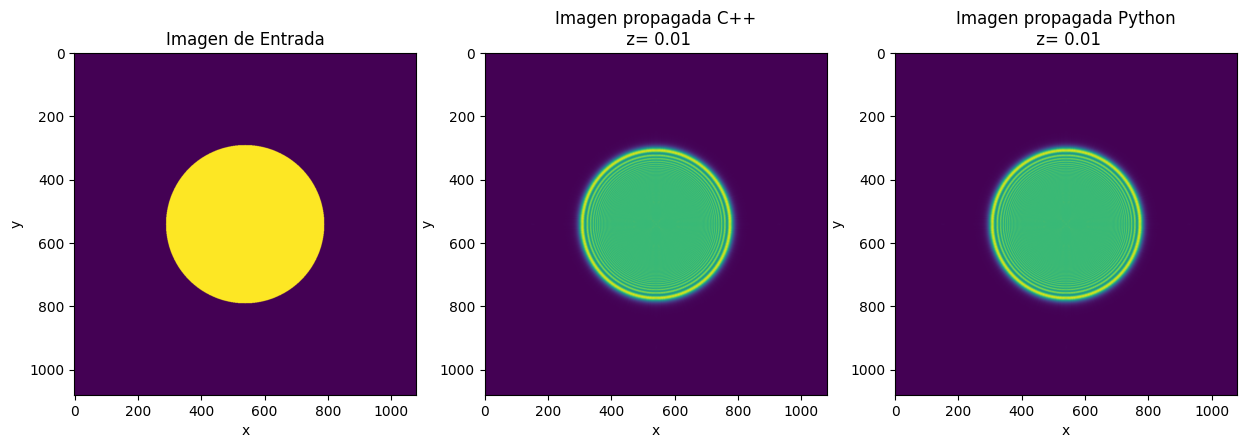

Tiempo de propagación en Python: 4.9155 segundos


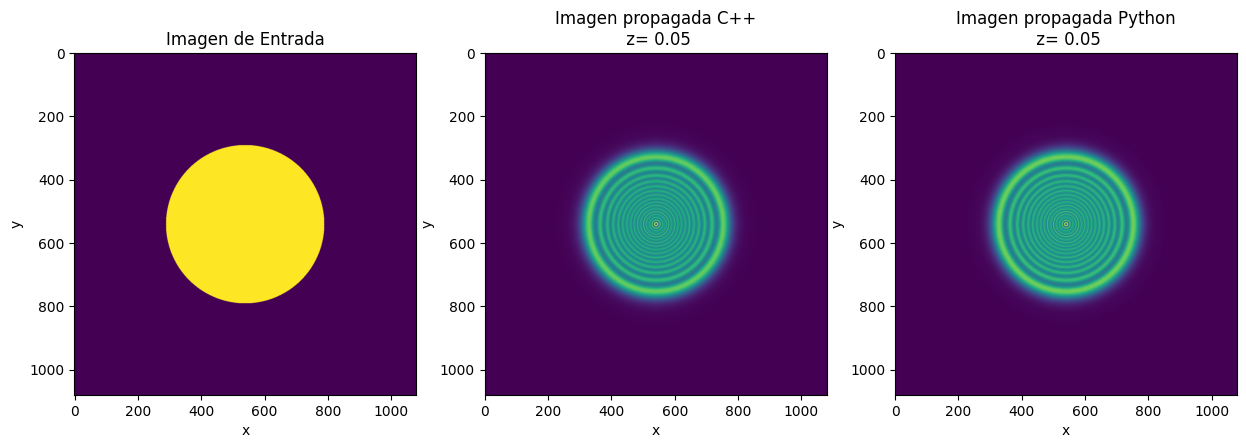

Precaucion: Los parametros de propagacíon implican un padding de mas de  1949  píxeles
Tiempo de propagación en Python: 13.8441 segundos


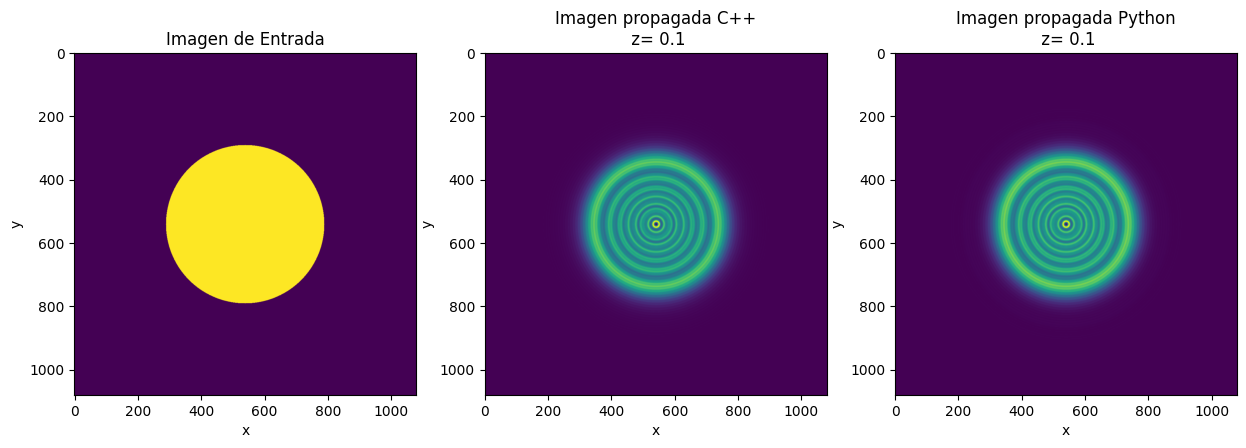

Precaucion: Los parametros de propagacíon implican un padding de mas de  2923  píxeles
Tiempo de propagación en Python: 19.6101 segundos


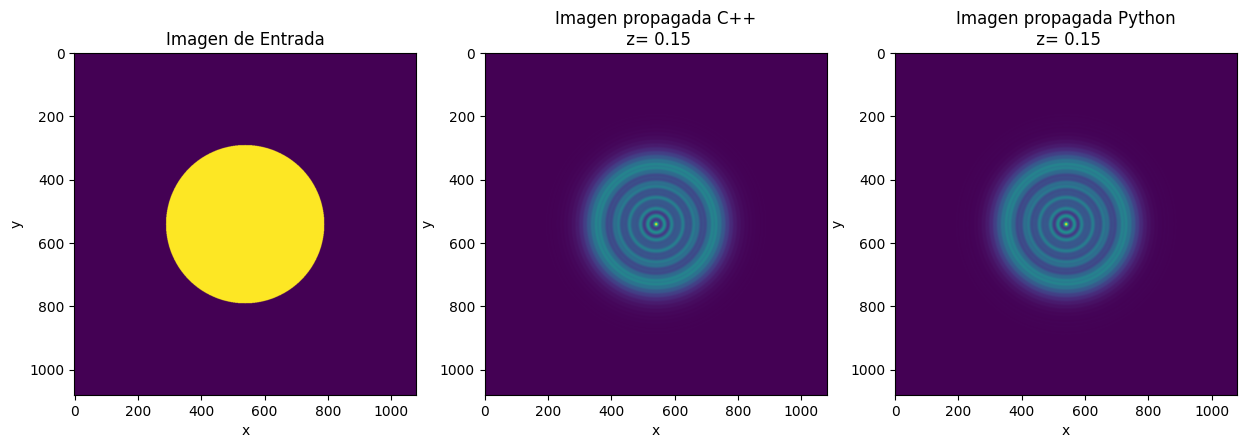

Tiempo de propagación en Python: 0.3380 segundos


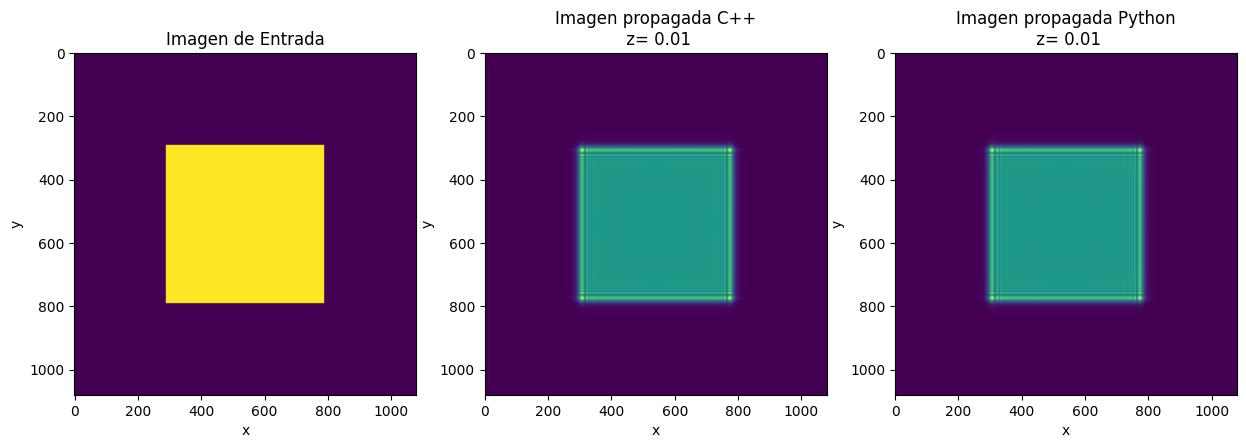

Tiempo de propagación en Python: 3.7252 segundos


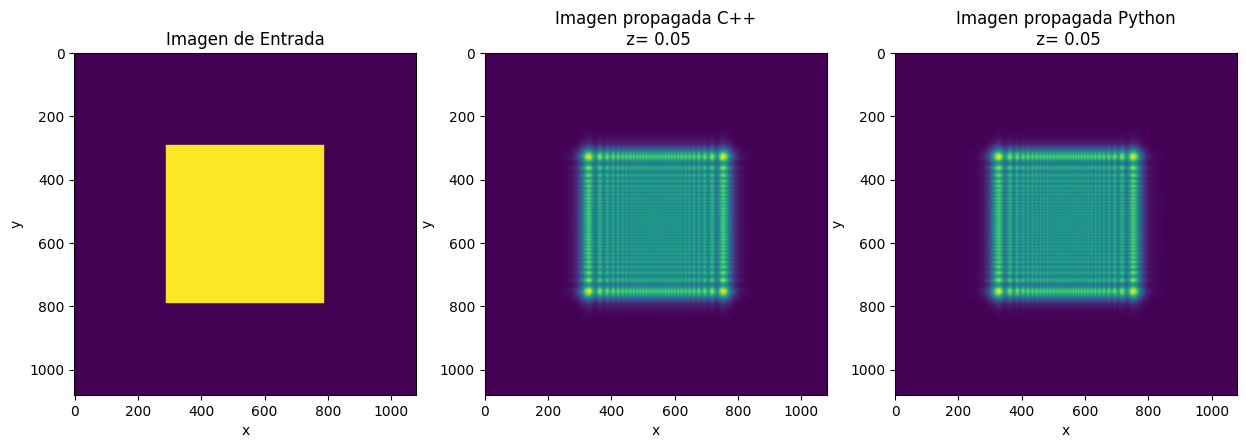

Precaucion: Los parametros de propagacíon implican un padding de mas de  1949  píxeles
Tiempo de propagación en Python: 14.0463 segundos


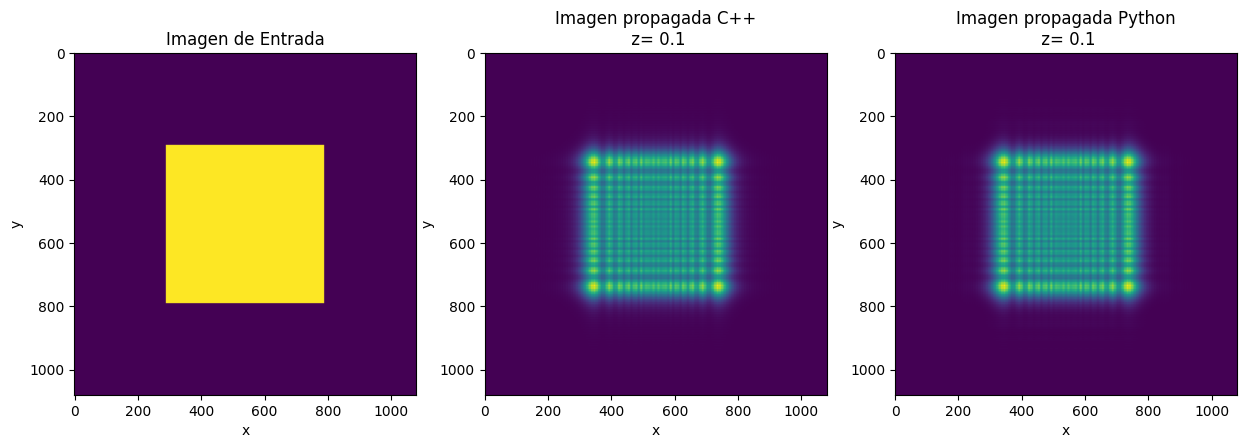

Precaucion: Los parametros de propagacíon implican un padding de mas de  2923  píxeles
Tiempo de propagación en Python: 22.9204 segundos


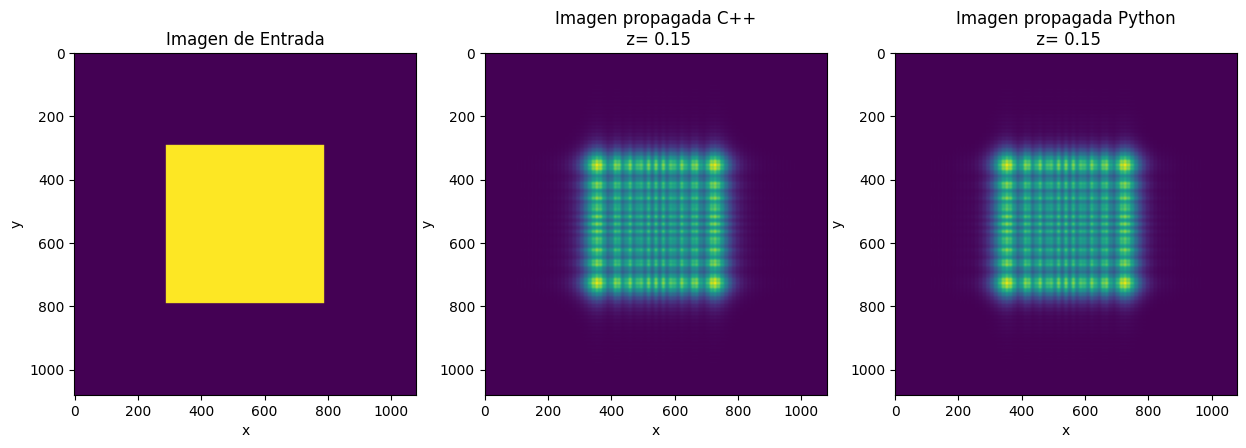

In [ ]:
zs = [0.01, 0.05, 0.1, 0.15]
for z in zs:
  distance_str = str(int(z * 1000))
  args.z = z

  amp_filename_circ = "output_amplitude_circ_z" + distance_str + ".csv"
  phase_filename_circ = "output_phase_circ_z" + distance_str + ".csv"
  plot_propagated_fields(amp_filename_circ, phase_filename_circ, sx, sy, args)

for  z in zs:
  distance_str = str(int(z * 1000))
  args.z = z
  amp_filename_A = "output_amplitude_A_z" + distance_str + ".csv"
  phase_filename_A = "output_phase_A_z" + distance_str + ".csv"
  plot_propagated_fields(amp_filename_A, phase_filename_A, sx, sy, args)


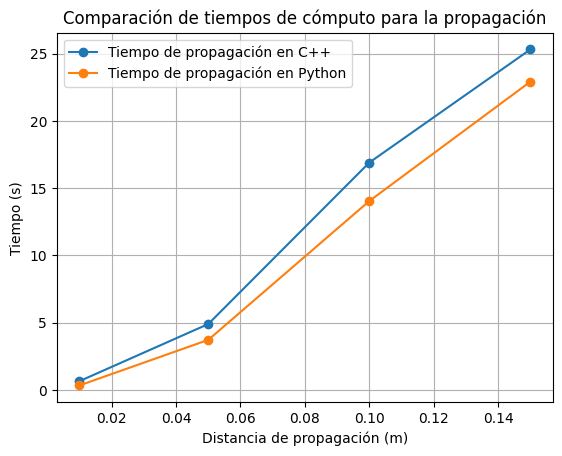

In [ ]:
t_cpp = np.array([654, 4901, 16905 , 25316])/1000
t_py = [ 0.3380, 3.7252, 14.0463,22.9204]

plt.plot(zs, t_cpp, label='Tiempo de propagación en C++', marker = "o")
plt.plot(zs, t_py, label='Tiempo de propagación en Python',marker = "o")
plt.grid()
plt.legend()
plt.xlabel('Distancia de propagación (m)')
plt.ylabel('Tiempo (s)')
plt.title('Comparación de tiempos de cómputo para la propagación')
plt.show()

In [ ]:
!ls

CMakeCache.txt			     output_amplitude_circ_z150.csv
CMakeFiles			     output_amplitude_circ_z200.csv
cmake_install.cmake		     output_amplitude_circ_z50.csv
detect_cuda_compute_capabilities.cu  output_phase_A_z100.csv
detect_cuda_version.cc		     output_phase_A_z150.csv
main				     output_phase_A_z200.csv
Makefile			     output_phase_A_z50.csv
output_amplitude_A_z100.csv	     output_phase_circ_z100.csv
output_amplitude_A_z150.csv	     output_phase_circ_z150.csv
output_amplitude_A_z200.csv	     output_phase_circ_z200.csv
output_amplitude_A_z50.csv	     output_phase_circ_z50.csv
output_amplitude_circ_z100.csv
